# Dealing With Imbalanced Datasets And Lack Of Domain Knowledge With Application On Credit Card Fraud Detection Models

 # Overview

Abstract

Data Acquisition

Exploratory Data Analysis

Preprocessing

Model Development

Testing

Interpreting The Results

Discussion On Limitations/Issues With Methodologies And Potential Expansions/Fixes

Conclusion

Resources

# Abstract

In this notebook we will see the effectiveness of different approaches to dealing with imbalanced data when also having no domain knowledge. Those techniques will be demonstrated in a practical example trying to develop a model that can detect credit card fraud.

# Data Acquisition

We will use the data in this kaggle competition https://www.kaggle.com/datasets/whenamancodes/fraud-detection/code?datasetId=2472961&sortBy=voteCount. The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


### Imports

first our imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from mglearn import plots
import warnings


In [2]:
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
#from google.colab import drive
# drive.mount('/content/gdrive')


In [4]:
data = pd.read_csv("creditcard.csv")


# Exploratory Data Analysis

In [5]:
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
def showLabelsCountPlot(data):
    sns.countplot(x='Class', data=data)
    plt.title("Fraud class histogram")
    plt.ylabel("Frequency")
    plt.xlabel("Class")
    plt.show()


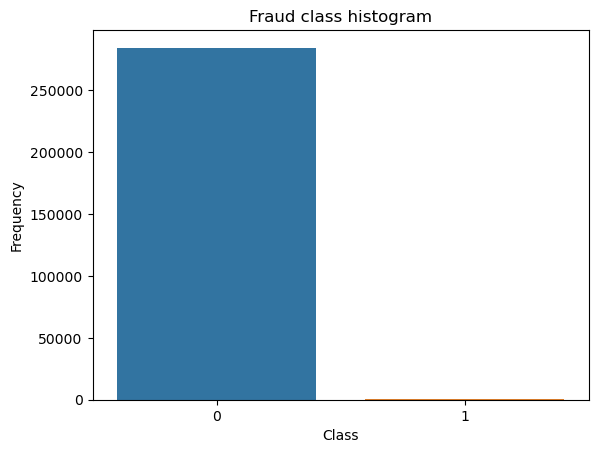

In [9]:
sns.countplot(x='Class', data=data)
plt.title("Fraud class histogram")
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.show()


In [10]:
np.sum(data.isna().sum() > 0)


0

<AxesSubplot:>

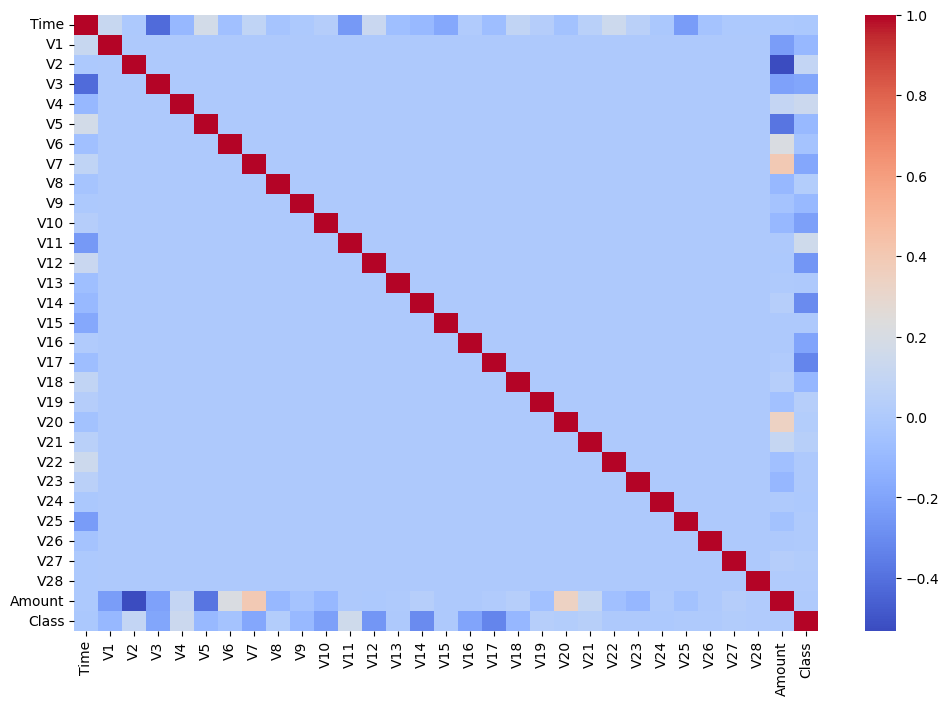

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm')


There don't seem to be any strong correlations nor positive or negative this is probably a result of the PCA.

Text(0.5, 1.0, 'Time')

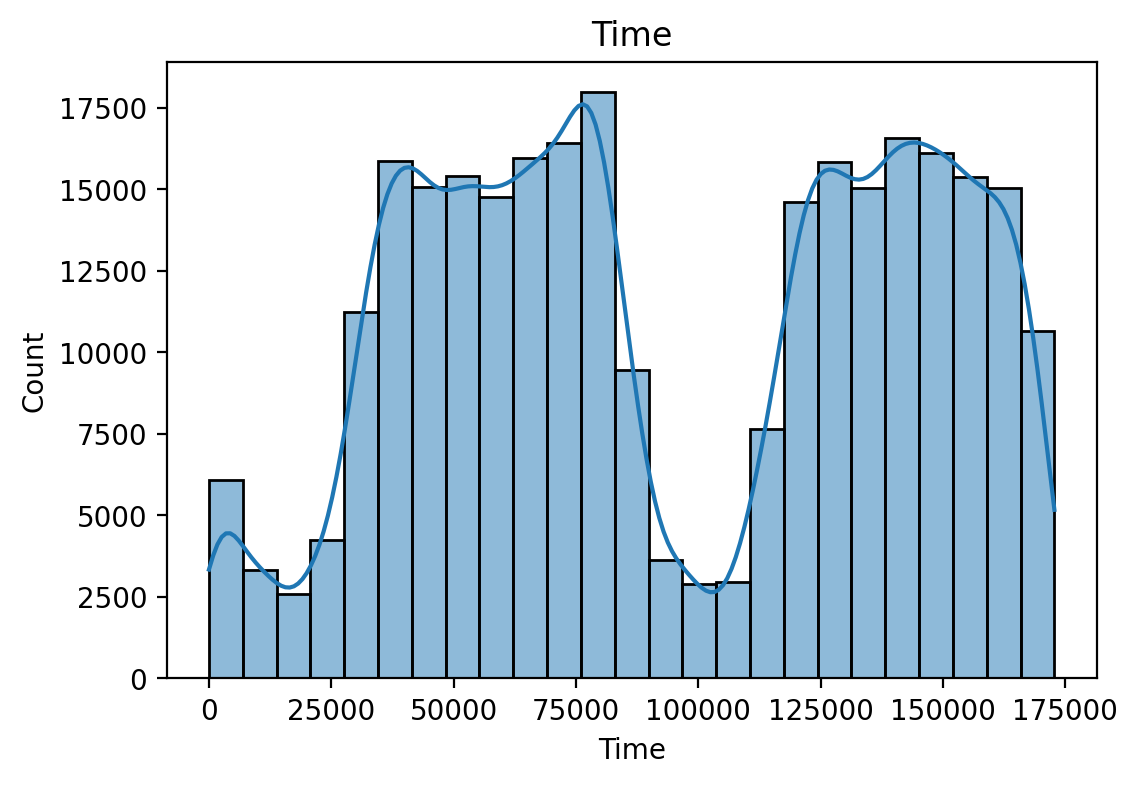

In [12]:
plt.figure(figsize=(6, 4), dpi=200)
sns.histplot(data=data, x='Time', kde=True, bins=25)
plt.title("Time")


Text(0.5, 1.0, 'Amount')

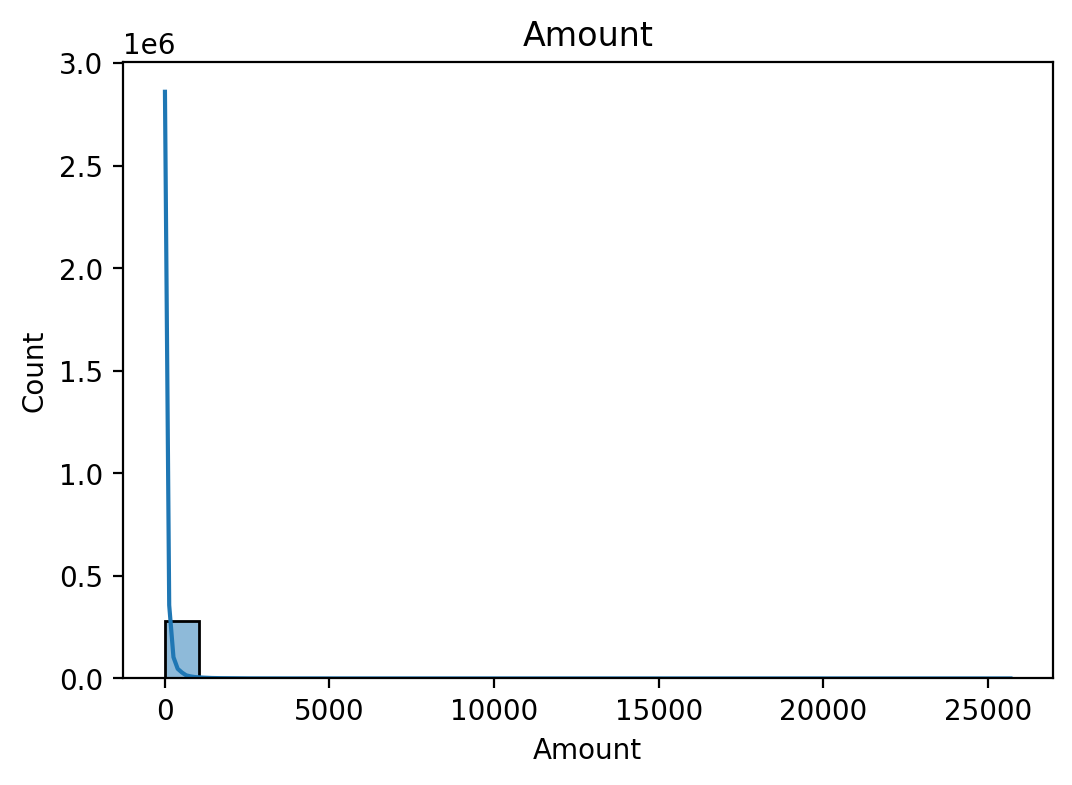

In [13]:
plt.figure(figsize=(6, 4), dpi=200)
sns.histplot(data=data, x='Amount', kde=True, bins=25)
plt.title("Amount")


The transaction amount is relatively small. There are very few transactions with big amounts the time distribution doesn't give us information that will allow us to make presumptions about the data. Due to the PCA preprocessing we can't really make any a prior assumption about the data. So we so the only thing that we can do to make a better model is to try to find ways to deal with the imbalanced class distribution. The techniques that we will use are going to be :

-Opting for f1 score instead of accuracy. 

-Undersample the data

-Oversample the data using NearMiss under-sampling

-Oversample the data using Synthetic Minority Over-sampling

-Oversample the data using Synthetic Minority Over-sampling during the cross validation process


# Preprocessing

### Spliting

We split the data into training and testing sets

In [14]:
attributes = data.drop(labels=["Class", "Amount"], axis=1)


In [15]:
labels = data["Class"]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    attributes, labels, stratify=labels, test_size=0.2, random_state=42)
    

In [17]:
print("Shape of training set: ", X_train.shape)
print("Shape of testing set: ", X_test.shape)


Shape of training set:  (227845, 29)
Shape of testing set:  (56962, 29)


In [18]:
print(f"train data positives count {sum(y_train.values)}")
print(f"test data positives count {sum(y_test.values)}")


train data positives count 394
test data positives count 98


### Scaling

We fit the standard scaler to the training data only in this project we are considering fitting the scaler to any non-training data to be data leakage.
We scale all the data even the pre-scaled data so that every variable has a normal distribution.

In [19]:
scaler = StandardScaler()


In [20]:
scaler.fit(X_train)


StandardScaler()

In [21]:
def scaleData(data, scaler):
    scaled_data = pd.DataFrame(scaler.transform(data))
    scaled_data.columns = data.columns

    return scaled_data


In [22]:
X_train_scaled = scaleData(X_train, scaler)


In [23]:
X_test_scaled = scaleData(X_test, scaler)


In [24]:
X_test_scaled.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,...,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,-0.007500,-0.002030,0.001458,0.001264,0.000070,-0.000633,0.004399,-0.000310,0.001821,-0.003197,...,-0.004076,0.006480,-0.002515,-0.002085,-0.000402,0.002290,0.006287,-0.001308,0.000870,-0.002351
std,0.999960,0.999423,1.006712,1.003183,1.000016,1.002464,1.003953,0.994601,1.012000,1.005829,...,1.000679,1.000767,0.997021,0.999775,0.976208,1.002694,1.000401,1.002994,0.983836,1.047210
min,-1.998031,-19.173238,-25.573036,-21.417574,-3.717199,-29.304793,-15.020249,-25.191133,-42.542060,-8.640969,...,-5.388054,-36.336901,-30.964787,-12.245976,-42.636973,-4.662171,-14.379486,-3.850042,-24.314484,-25.730899
25%,-0.858977,-0.471080,-0.362177,-0.584066,-0.603929,-0.500121,-0.575310,-0.449328,-0.176847,-0.597040,...,-0.568197,-0.273938,-0.312672,-0.749125,-0.257461,-0.583210,-0.609301,-0.683258,-0.176023,-0.163021
50%,-0.219182,0.007016,0.042164,0.118846,-0.009511,-0.037891,-0.205314,0.031453,0.015833,-0.049277,...,-0.003434,-0.079198,-0.041395,0.010586,-0.019091,0.069212,0.037378,-0.111932,0.002384,0.034157
75%,0.931985,0.671272,0.487140,0.679519,0.527829,0.446335,0.303979,0.460224,0.273629,0.539837,...,0.558174,0.175609,0.253217,0.728904,0.235553,0.731236,0.681922,0.500435,0.223822,0.241028
max,1.640423,1.252799,10.873297,2.789231,8.568862,20.848943,17.967805,35.572826,15.344455,8.315344,...,6.869530,34.040278,37.012128,11.398021,30.287490,6.646304,14.427753,6.465715,25.949859,69.187083


## Under Sample 

The two undersamling techniques we will use random undersamling and undersamling with the NearMiss algorithm.(for more information visit https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)

### Random Under Sample 

In [25]:
def underSampleData(X_train, y_train, positive_label=1):

    positive_count = len(y_train[y_train == positive_label])
    positive_indices = np.array(y_train[y_train == positive_label].index)

    negative_indices = y_train[y_train != positive_label].index

    random_negative_indices = np.random.choice(
        negative_indices, positive_count, replace=False)
    random_negative_indices = np.array(random_negative_indices)

    under_sample_indices = np.concatenate(
        [positive_indices, random_negative_indices])

    y_train_under_sample = y_train.loc[under_sample_indices]

    X_train_under_sample = X_train.loc[under_sample_indices]

    return X_train_under_sample, y_train_under_sample


In [26]:
X_train_under_sample, y_train_under_sample = underSampleData(X_train, y_train)


In [27]:
X_train_under_sample_scaled = scaleData(X_train_under_sample, scaler)


In [28]:
X_train_under_sample_scaled.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,...,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000,788.000000
mean,-0.129662,-1.167803,1.055323,-2.351689,1.623478,-1.145238,-0.493134,-2.254818,0.238008,-1.142288,...,0.385093,0.219103,0.442992,0.038251,-0.048072,-0.072890,0.036701,0.069601,0.236655,0.106587
std,1.011560,2.844993,2.273215,4.116097,2.269375,3.069567,1.357047,4.771565,4.003910,2.134077,...,1.570362,1.506532,3.680060,1.589871,2.158916,0.931615,1.317950,0.975061,2.486014,1.318900
min,-1.978131,-15.596939,-10.132574,-20.526316,-2.381555,-16.023665,-4.335905,-35.171457,-34.447787,-12.242932,...,-4.524434,-11.870544,-31.019299,-12.245976,-30.688319,-3.750545,-9.172358,-2.481774,-17.937316,-8.685628
25%,-1.003238,-1.405510,-0.141365,-3.385171,-0.060799,-1.302136,-1.180270,-2.411681,-0.172102,-2.118875,...,-0.532508,-0.269317,-0.234837,-0.719312,-0.383790,-0.663595,-0.566586,-0.543294,-0.154828,-0.159452
50%,-0.258666,-0.358390,0.589066,-0.944618,0.923614,-0.349631,-0.472406,-0.570998,0.132443,-0.624592,...,0.275580,0.023148,0.214964,0.053162,-0.047624,0.004290,0.102864,-0.054693,0.129558,0.097990
75%,0.839457,0.576474,1.650933,0.189331,3.046377,0.333759,0.064918,0.180682,0.742866,0.189390,...,1.165407,0.520617,0.881901,0.803917,0.302175,0.609349,0.744212,0.672081,1.123893,0.675424
max,1.620986,1.166827,13.375999,1.963981,8.556395,8.042321,4.864193,6.538544,16.792270,5.582470,...,5.959479,14.348654,37.012128,11.521692,15.897219,2.430834,4.339921,5.696032,10.802421,5.442034


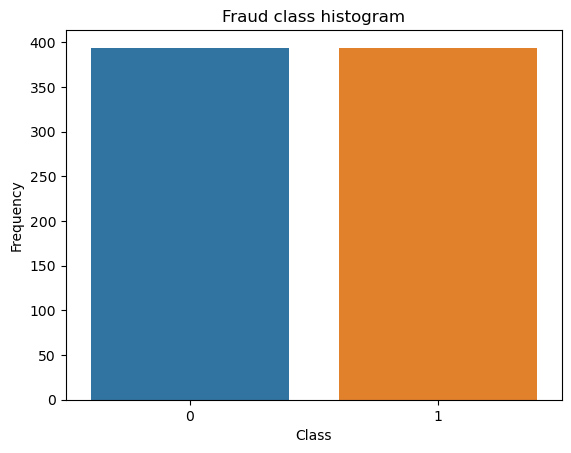

In [29]:
sns.countplot(x='Class', data=pd.DataFrame(y_train_under_sample))
plt.title("Fraud class histogram")
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.show()


<AxesSubplot:>

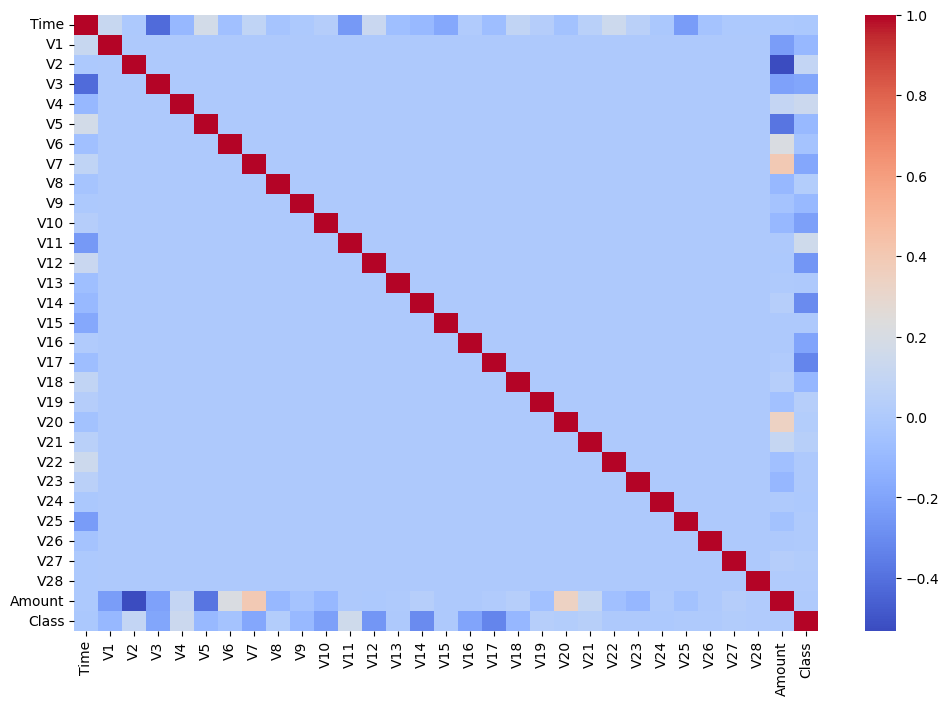

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm')


<AxesSubplot:>

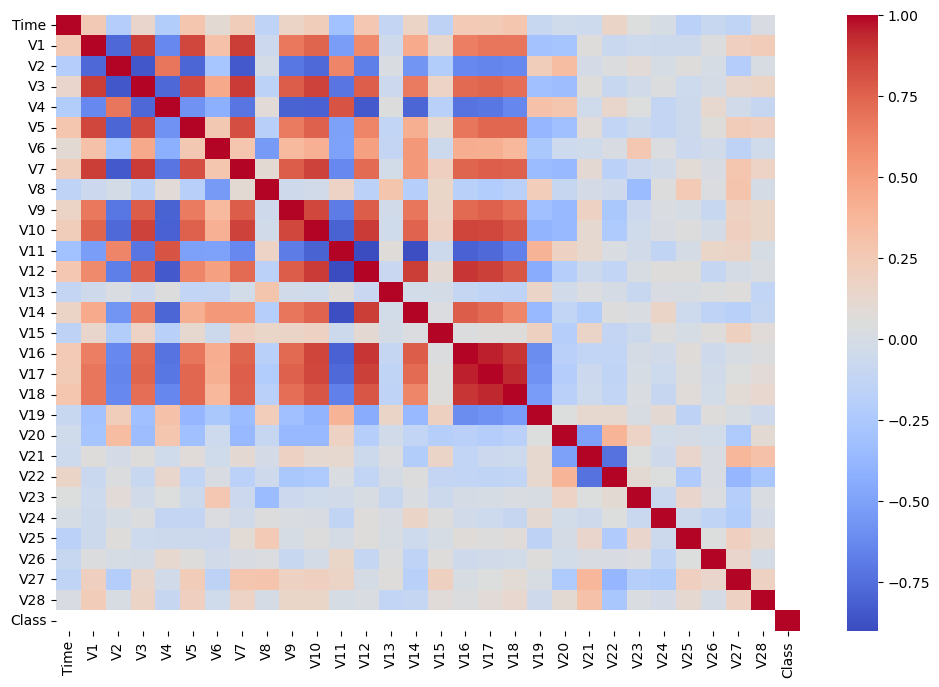

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.concat([X_train_under_sample_scaled, pd.DataFrame(
    y_train_under_sample)], axis=0).corr(), cmap='coolwarm')


Now we see significant correlations seem that the lack of previous correlations was due to the lack positive labels in the data.

### Under Sample NearMiss

In [32]:
nm = NearMiss()


In [33]:
X_train_under_nm, y_train_under_sample_nm = nm.fit_resample(X_train, y_train)


In [34]:
X_train_under_sample_scaled_nm = scaleData(X_train_under_nm, scaler)


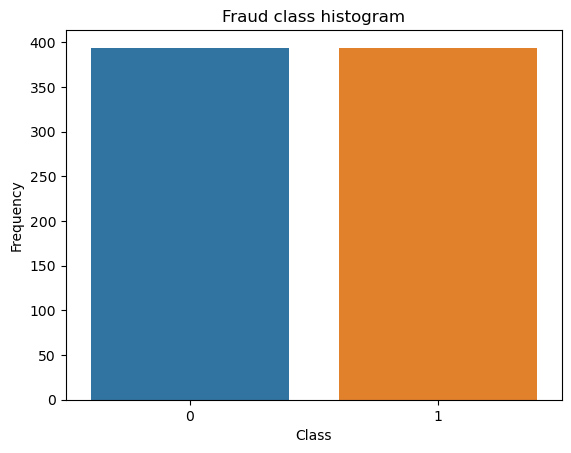

In [35]:
sns.countplot(x='Class', data=pd.DataFrame(y_train_under_sample_nm))
plt.title("Fraud class histogram")
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.show()


<AxesSubplot:>

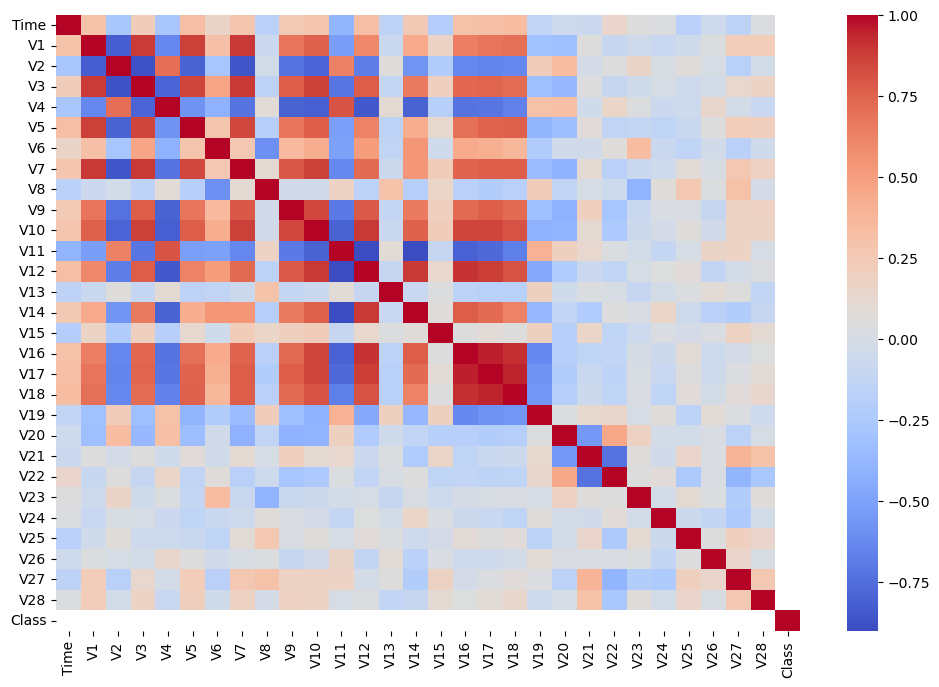

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.concat([X_train_under_sample_scaled_nm, pd.DataFrame(
    y_train_under_sample_nm)], axis=0).corr(), cmap='coolwarm')


Again we see similar results.

## Undersample + PCA

Because we saw higher correlations when undersampling the data we will try to perform PCA analysis on the data undersampled data to see what explained variance we will see and to see if we potentially get better results.

In [37]:
pca = PCA()
pca.fit(X_train_under_sample_scaled)


PCA()

In [38]:
number_pcs = len(pca.explained_variance_ratio_)
total_explained_variance = np.cumsum(pca.explained_variance_ratio_)


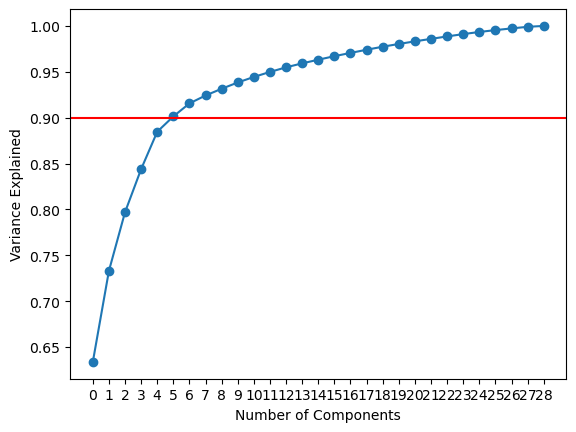

In [39]:
number_pcs = len(pca.explained_variance_ratio_)
total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(total_explained_variance)
plt.scatter(range(number_pcs), total_explained_variance)
plt.xticks(range(number_pcs))

plt.axhline(0.9, c="r")

plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.show()


It seems that we can get 90% explained variance with only 6 components.

In [40]:
pca = PCA(n_components=6)


In [41]:
X_train_pca = pca.fit_transform(X_train_under_sample_scaled)


In [42]:
X_test_pca = pca.transform(X_test_scaled)


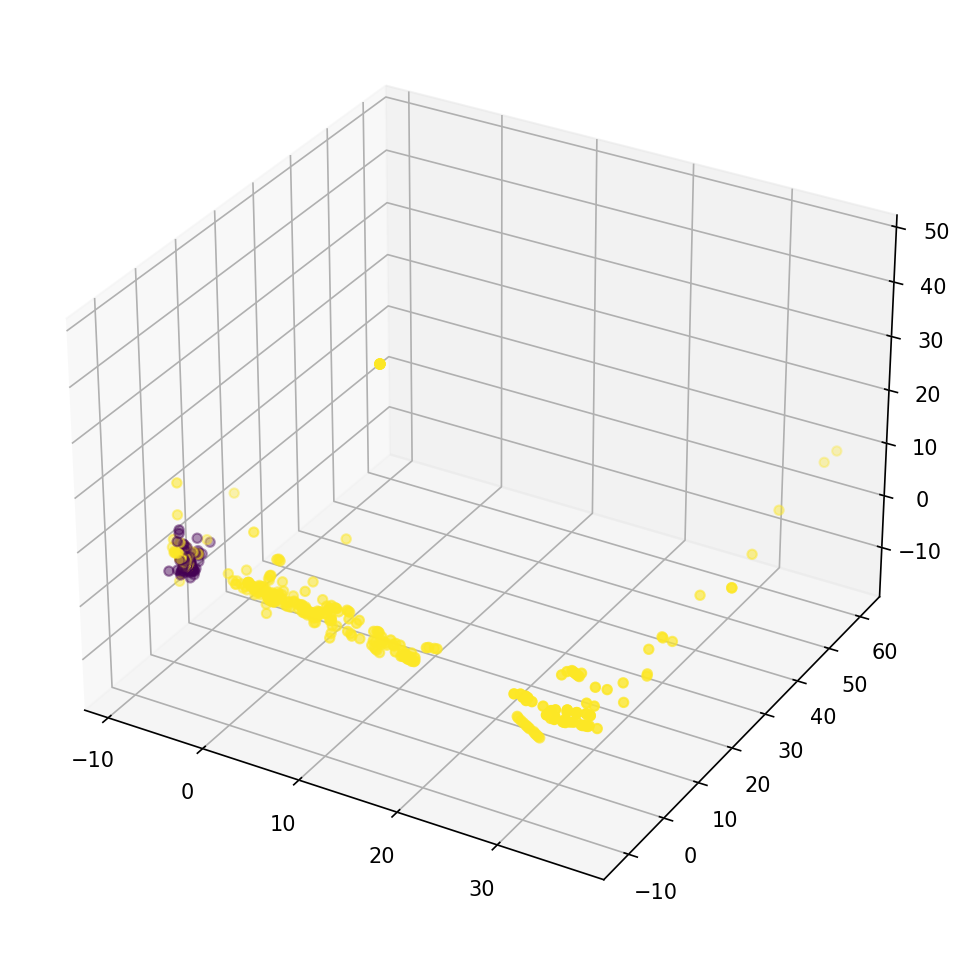

In [43]:
plt.figure(figsize=(8, 8), dpi=150)
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_pca[:, 0], X_train_pca[:, 1],
             X_train_pca[:, 2], c=y_train_under_sample)


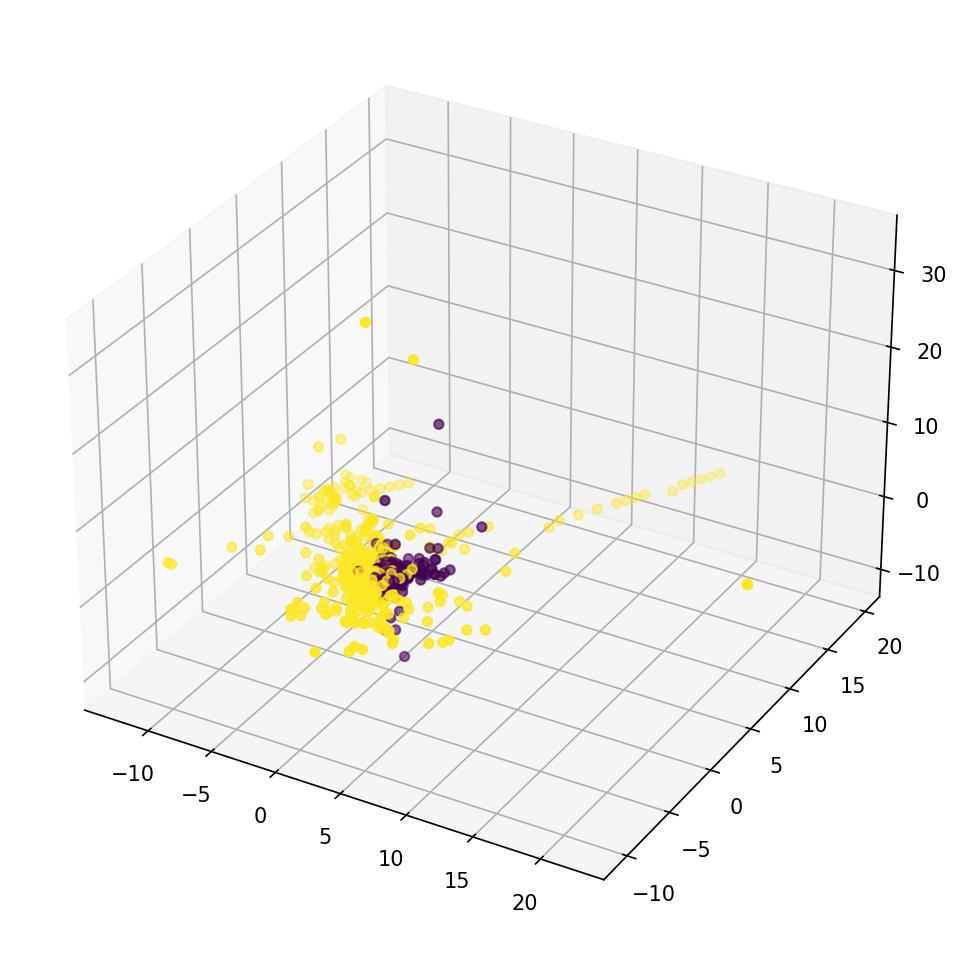

In [44]:
plt.figure(figsize=(8, 8), dpi=150)
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_pca[:, 3], X_train_pca[:, 4],
             X_train_pca[:, 5], c=y_train_under_sample)


It seems like we are getting some meaningful separation between the classes that might help for a better model.

## Over Sample

We will oversample the data using the Synthetic Minority Over-sampling algorithm before the cross-validation.(for more information visit https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c)

### SMOTE Over Sample Before CV

In [45]:
smote = SMOTE()


In [46]:
X_train_over_smote, y_train_over_smote = smote.fit_resample(X_train, y_train)


In [47]:
X_train_over_scaled_smote = scaleData(X_train_over_smote, scaler)


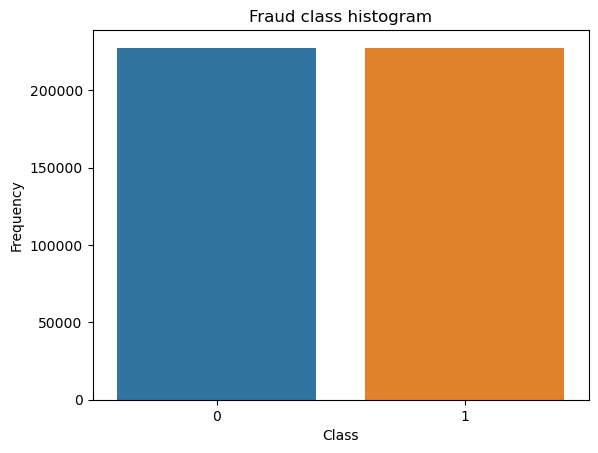

In [48]:
sns.countplot(x='Class', data=pd.DataFrame(y_train_over_smote))
plt.title("Fraud class histogram")
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.show()


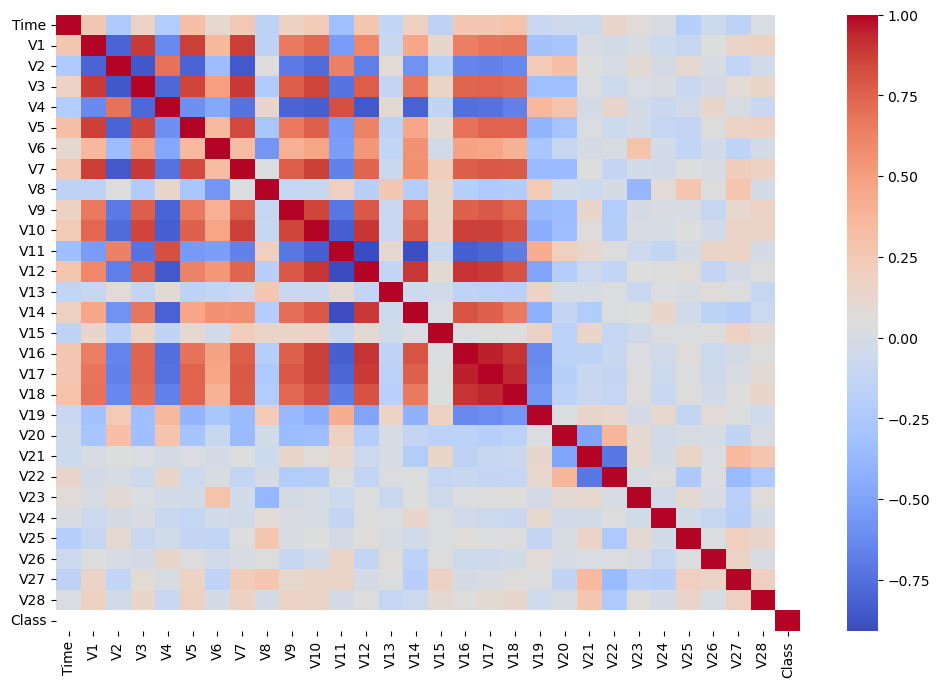

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.concat([X_train_over_scaled_smote, pd.DataFrame(
    y_train_over_smote)], axis=0).corr(), cmap='coolwarm')
plt.show()


### SMOTE Over Sample During CV

The previous oversampling technique can potentially produce extreme overfitting. Because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. 

![image](oversamlingWrong.jpg)



To fix this problem we need to do the smote oversampling the cross-validation process this will be show in the model development section below.

As shown below by performing SMOTE oversampling during cross validation and not prior to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.

![image](oversamplingRight.jpg)



# Model Development

We shall use grid search cross validation to with same parameters to find the best how will the different sampling techniques perform and how will the optimal parameters change.(Note that you can just use the "unPickleModels" function to load the already trained models.)

## Utilities ----------------------------------------------------------------|

These are some helper functions to make the training process easier.

In [50]:
def pickleModels(models, folder):
    pickle_out = open((folder + ".pickle"), "wb")
    pickle.dump(models, pickle_out)
    pickle_out.close()


In [51]:
def unPickleModels(folder):
    pickle_in = open((folder + ".pickle"), "rb")
    models = pickle.load(pickle_in)
    pickle_in.close()

    return models


In [52]:
def trainModels(attributes, labels, models, param_grids, scoring=make_scorer(f1_score, pos_label=1), cv=5):
    GridSearchModels = {}

    for model, param_grid in zip(models, param_grids):

        grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv)
        grid_search.fit(attributes, labels)
        GridSearchModels[grid_search.estimator.__class__.__name__] = grid_search

        print(f"{grid_search.estimator.__class__.__name__} model fitted successfully")

    return GridSearchModels


In [53]:
def getModelsClassificationReport(attributes, labels, models, scoring=classification_report):

    result = pd.DataFrame({'Model': []})

    for model in models:

        print(f"Model : {model}")
        print(f"Best params : {models[model].best_params_}")

        start = time.time()
        score = scoring(models[model].predict(
            attributes), labels, output_dict=True)
        end = time.time()

        result = pd.DataFrame(
            pd.concat([result, pd.DataFrame(score).transpose()], axis=0)).fillna(model)

        print(f"Took {end - start} seconds\n")

    return result.round(decimals=2)


In [54]:
def trainModelsSMOTE(attributes, labels, models, param_grids, scoring=make_scorer(f1_score, pos_label=1), cv=5):

    def addUnderscore(dict):
        res = {}
        for k, v in dict.items():
            res["classification__"+k] = v
        return res

    smote_models = [Pipeline(
        [("sampling", SMOTE()), ("classification", model)]) for model in models]
    smote_param_grids = [addUnderscore(param_grid)
                         for param_grid in param_grids]
    GridSearchModels = {}

    for model, param_grid in zip(smote_models, smote_param_grids):
        grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv)
        grid_search.fit(attributes, labels)
        GridSearchModels[grid_search.estimator['classification'].__class__.__name__] = grid_search
        pickleModels(
            grid_search, grid_search.estimator['classification'].__class__.__name__)
        print(
            f"{grid_search.estimator['classification'].__class__.__name__} model fitted successfully")

    return GridSearchModels


## Training

In [55]:
scorer = make_scorer(f1_score, pos_label=1)


In [56]:
k_fold = StratifiedKFold(n_splits=5)


In [57]:
linear_model_param_grid = {
    'solver': ["saga"],
    'C': [0.0001, 0.001,0.01, 0.1, 1, 10],
    'l1_ratio': [0, .1, .5, .7, .9, .99],
    "penalty": ["elasticnet"],
    "max_iter": [100000]}


In [58]:
KNN_param_grid = {"n_neighbors": list(range(1, 31, 5))}


In [59]:
SVC_param_grid = {'C': [0.001, 0.01, 0.1, 0.5,
                        0, 7, 1], 'kernel': ['rbf', 'linear']}


In [60]:
tree_param_grid = {"max_depth": list(range(2, 7, 2)),
                   "min_samples_leaf": list(range(2, 7, 2)), "max_leaf_nodes": [15, 20]}


In [61]:
forest_param_grid = {
    "n_estimators": [300, 400],
    "max_depth": [20, 50, 100]
}


In [62]:
ada_param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.001, 0.01, 0.1, 0.5]
}


In [63]:
models = [LogisticRegression(), KNeighborsClassifier(), SVC(
), DecisionTreeClassifier(), RandomForestClassifier(), AdaBoostClassifier()]
param_grids = [linear_model_param_grid, KNN_param_grid,
               SVC_param_grid, tree_param_grid, forest_param_grid, ada_param_grid]
scoring = make_scorer(f1_score, pos_label=1)
cv = 5


In [64]:
under_sample_models = trainModels(X_train_under_sample_scaled, y_train_under_sample, models, param_grids, scoring, cv )


In [65]:
pickleModels(under_sample_models, "under_sample_models")


In [66]:
#under_sample_models = unPickleModels("under_sample_models")


In [67]:
cl_report_under_sample_models_train = getModelsClassificationReport(
    X_train_under_sample_scaled, y_train_under_sample, under_sample_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0.1, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.0030922889709472656 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.06599593162536621 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.0069730281829833984 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 2}
Took 0.004007101058959961 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 50, 'n_estimators': 300}
Took 0.028997421264648438 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.01, 'n_estimators': 400}
Took 0.050018310546875 seconds



In [68]:
cl_report_under_sample_models_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.96,0.94,0.95,405.00
1,LogisticRegression,0.93,0.96,0.95,383.00
accuracy,LogisticRegression,0.95,0.95,0.95,0.95
macro avg,LogisticRegression,0.95,0.95,0.95,788.00
weighted avg,LogisticRegression,0.95,0.95,0.95,788.00
0,KNeighborsClassifier,0.99,0.90,0.94,435.00
1,KNeighborsClassifier,0.89,0.99,0.94,353.00
accuracy,KNeighborsClassifier,0.94,0.94,0.94,0.94
macro avg,KNeighborsClassifier,0.94,0.95,0.94,788.00
weighted avg,KNeighborsClassifier,0.95,0.94,0.94,788.00


In [69]:
cl_report_under_sample_models_train = getModelsClassificationReport(
    X_train_under_sample_scaled, y_train_under_sample, under_sample_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0.1, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.0033769607543945312 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.06161069869995117 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.005092144012451172 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 2}
Took 0.0019943714141845703 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 50, 'n_estimators': 300}
Took 0.025024890899658203 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.01, 'n_estimators': 400}
Took 0.04998469352722168 seconds



In [70]:
cl_report_under_sample_models_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.96,0.94,0.95,405.00
1,LogisticRegression,0.93,0.96,0.95,383.00
accuracy,LogisticRegression,0.95,0.95,0.95,0.95
macro avg,LogisticRegression,0.95,0.95,0.95,788.00
weighted avg,LogisticRegression,0.95,0.95,0.95,788.00
0,KNeighborsClassifier,0.99,0.90,0.94,435.00
1,KNeighborsClassifier,0.89,0.99,0.94,353.00
accuracy,KNeighborsClassifier,0.94,0.94,0.94,0.94
macro avg,KNeighborsClassifier,0.94,0.95,0.94,788.00
weighted avg,KNeighborsClassifier,0.95,0.94,0.94,788.00


In [71]:
under_sample_models_nm = trainModels(X_train_under_sample_scaled_nm, y_train_under_sample_nm, models, param_grids, scoring, cv )


In [72]:
pickleModels(under_sample_models_nm, "under_sample_models_nm")


In [73]:
#under_sample_models_nm = unPickleModels("under_sample_models_nm")


In [74]:
cl_report_under_sample_models_nm_train = getModelsClassificationReport(
    X_train_under_sample_scaled_nm, y_train_under_sample_nm, under_sample_models_nm)


Model : LogisticRegression
Best params : {'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.0029850006103515625 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.05583643913269043 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.003987550735473633 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 2}
Took 0.0030062198638916016 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 20, 'n_estimators': 400}
Took 0.031019210815429688 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.5, 'n_estimators': 300}
Took 0.03745460510253906 seconds



In [75]:
cl_report_under_sample_models_nm_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.99,0.92,0.95,423.00
1,LogisticRegression,0.91,0.99,0.95,365.00
accuracy,LogisticRegression,0.95,0.95,0.95,0.95
macro avg,LogisticRegression,0.95,0.95,0.95,788.00
weighted avg,LogisticRegression,0.95,0.95,0.95,788.00
0,KNeighborsClassifier,0.99,0.90,0.94,432.00
1,KNeighborsClassifier,0.89,0.99,0.94,356.00
accuracy,KNeighborsClassifier,0.94,0.94,0.94,0.94
macro avg,KNeighborsClassifier,0.94,0.94,0.94,788.00
weighted avg,KNeighborsClassifier,0.94,0.94,0.94,788.00


In [76]:
under_sample_models_pca = trainModels(X_train_pca, y_train_under_sample, models, param_grids, scoring, cv )


In [77]:
pickleModels(under_sample_models_pca, "under_sample_models_pca")


In [78]:
#under_sample_models_pca = unPickleModels("under_sample_models_pca")


In [79]:
cl_report_under_sample_models_pca_train = getModelsClassificationReport(
    X_train_pca, y_train_under_sample, under_sample_models_pca)


Model : LogisticRegression
Best params : {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.002924203872680664 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.013522863388061523 seconds

Model : SVC
Best params : {'C': 1, 'kernel': 'rbf'}
Took 0.008206367492675781 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 2}
Took 0.002031087875366211 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 50, 'n_estimators': 400}
Took 0.03090214729309082 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.01, 'n_estimators': 300}
Took 0.03439044952392578 seconds



We shall also train a models without performing any sampling. Those models are going to be out "control" models. We will use them to see how much we actually benefit from these sampling techniques compared to just using the f1 scoring system. Note that we are using StratifiedKFold cross-validation to so that the validation sets are balanced in every fold.

Using stratified fold we will make sure that in each validation fold the classes will be balanced so that we don't overfit to the majority class.


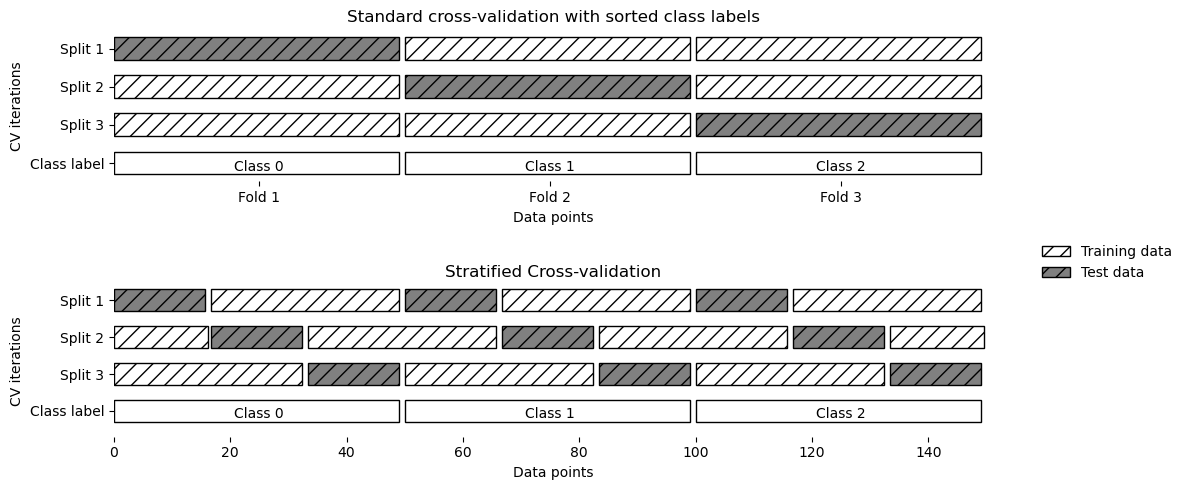

In [80]:
plots.plot_stratified_cross_validation()


In [81]:
#no_sampling_models = trainModels(X_train_scaled, y_train, models, param_grids, scoring, cv=StratifiedKFold(n_splits= 2))


In [82]:
#pickleModels(no_sampling_models, "no_sampling_models")


In [83]:
no_sampling_models = unPickleModels("no_sampling_models")


In [84]:
cl_report_no_sampling_models_train = getModelsClassificationReport(
    X_train_scaled, y_train, no_sampling_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0.5, 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.18746519088745117 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}


KeyboardInterrupt: 

In [ ]:
cl_report_no_sampling_models_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,1.00,1.00,1.00,227563.0
1,LogisticRegression,0.64,0.89,0.74,282.0
accuracy,LogisticRegression,1.00,1.00,1.00,1.0
macro avg,LogisticRegression,0.82,0.94,0.87,227845.0
weighted avg,LogisticRegression,1.00,1.00,1.00,227845.0
0,KNeighborsClassifier,1.00,1.00,1.00,227517.0
1,KNeighborsClassifier,0.76,0.91,0.83,328.0
accuracy,KNeighborsClassifier,1.00,1.00,1.00,1.0
macro avg,KNeighborsClassifier,0.88,0.96,0.92,227845.0
weighted avg,KNeighborsClassifier,1.00,1.00,1.00,227845.0


In [ ]:
#over_before_sampling_models = trainModels(X_train_over_scaled_smote, y_train_over_smote, models, param_grids, scoring, cv)


In [ ]:
#pickleModels(over_before_sampling_models, "over_before_sampling_models")


In [ ]:
over_before_sampling_models = unPickleModels("over_before_sampling_models")


In [ ]:
cl_report_over_before_sampling_models_train = getModelsClassificationReport(
    X_train_over_scaled_smote, y_train_over_smote, over_before_sampling_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.4005608558654785 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 9.03423261642456 seconds

Model : SVC
Best params : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Took 1.1073689460754395 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 3}
Took 0.3930473327636719 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 20, 'n_estimators': 400}
Took 8.026644468307495 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.1, 'n_estimators': 100}
Took 5.424058675765991 seconds



In [ ]:
cl_report_over_before_sampling_models_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.96,0.98,0.97,223659.00
1,LogisticRegression,0.98,0.96,0.97,231243.00
accuracy,LogisticRegression,0.97,0.97,0.97,0.97
macro avg,LogisticRegression,0.97,0.97,0.97,454902.00
weighted avg,LogisticRegression,0.97,0.97,0.97,454902.00
0,KNeighborsClassifier,0.99,0.92,0.95,244505.00
1,KNeighborsClassifier,0.91,0.99,0.95,210397.00
accuracy,KNeighborsClassifier,0.95,0.95,0.95,0.95
macro avg,KNeighborsClassifier,0.95,0.95,0.95,454902.00
weighted avg,KNeighborsClassifier,0.95,0.95,0.95,454902.00


Oversampling during cross-validation

In [ ]:
#smote_during_cv_models = trainModelsSMOTE(X_train_scaled, y_train, models, param_grids, scoring, cv )


In [ ]:
#pickleModels(smote_during_cv_models, "smote_during_cv_models")


In [ ]:
smote_during_cv_models = unPickleModels("smote_during_cv_models")


In [ ]:
cl_report_smote_during_cv_models_train = getModelsClassificationReport(
    X_train_scaled, y_train, smote_during_cv_models)


Model : LogisticRegression
Best params : {'classification__C': 0.01, 'classification__l1_ratio': 0.9, 'classification__max_iter': 100000, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
Took 0.1679682731628418 seconds

Model : KNeighborsClassifier
Best params : {'classification__n_neighbors': 1}
Took 51.96932816505432 seconds

Model : SVC
Best params : {'classification__C': 0.001, 'classification__kernel': 'rbf'}
Took 1204.406974554062 seconds

Model : DecisionTreeClassifier
Best params : {'classification__max_depth': 2, 'classification__max_leaf_nodes': 20, 'classification__min_samples_leaf': 2}
Took 0.20218682289123535 seconds

Model : RandomForestClassifier
Best params : {'classification__max_depth': 100, 'classification__n_estimators': 300}
Took 6.05717658996582 seconds

Model : AdaBoostClassifier
Best params : {'classification__learning_rate': 0.5, 'classification__n_estimators': 400}
Took 12.824611186981201 seconds



In [ ]:
cl_report_smote_during_cv_models_train


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.97,1.00,0.99,221669.00
1,LogisticRegression,0.93,0.06,0.11,6176.00
accuracy,LogisticRegression,0.97,0.97,0.97,0.97
macro avg,LogisticRegression,0.95,0.53,0.55,227845.00
weighted avg,LogisticRegression,0.97,0.97,0.96,227845.00
0,KNeighborsClassifier,1.00,1.00,1.00,227451.00
1,KNeighborsClassifier,1.00,1.00,1.00,394.00
accuracy,KNeighborsClassifier,1.00,1.00,1.00,1.00
macro avg,KNeighborsClassifier,1.00,1.00,1.00,227845.00
weighted avg,KNeighborsClassifier,1.00,1.00,1.00,227845.00


# Testing

In [ ]:
cl_report_under_sample_models_test = getModelsClassificationReport(
    X_test_scaled, y_test, under_sample_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0.1, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.05640411376953125 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.7426228523254395 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.13607168197631836 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 2}
Took 0.03759121894836426 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 50, 'n_estimators': 300}
Took 1.2067177295684814 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.01, 'n_estimators': 400}
Took 3.108192205429077 seconds



In [ ]:
cl_report_under_sample_models_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.96,1.00,0.98,54748.00
1,LogisticRegression,0.92,0.04,0.08,2214.00
accuracy,LogisticRegression,0.96,0.96,0.96,0.96
macro avg,LogisticRegression,0.94,0.52,0.53,56962.00
weighted avg,LogisticRegression,0.96,0.96,0.95,56962.00
0,KNeighborsClassifier,0.99,1.00,0.99,56069.00
1,KNeighborsClassifier,0.89,0.10,0.18,893.00
accuracy,KNeighborsClassifier,0.99,0.99,0.99,0.99
macro avg,KNeighborsClassifier,0.94,0.55,0.58,56962.00
weighted avg,KNeighborsClassifier,0.98,0.99,0.98,56962.00


In [ ]:
cl_report_under_sample_models_nm_test = getModelsClassificationReport(
    X_test_scaled, y_test, under_sample_models_nm)


Model : LogisticRegression
Best params : {'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.06642436981201172 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 0.82509446144104 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.13883185386657715 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 2}
Took 0.05208325386047363 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 20, 'n_estimators': 400}
Took 1.3463773727416992 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.5, 'n_estimators': 300}
Took 2.3456900119781494 seconds



In [ ]:
cl_report_under_sample_models_nm_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.97,1.00,0.99,55349.00
1,LogisticRegression,0.92,0.06,0.11,1613.00
accuracy,LogisticRegression,0.97,0.97,0.97,0.97
macro avg,LogisticRegression,0.95,0.53,0.55,56962.00
weighted avg,LogisticRegression,0.97,0.97,0.96,56962.00
0,KNeighborsClassifier,0.99,1.00,0.99,56076.00
1,KNeighborsClassifier,0.91,0.10,0.18,886.00
accuracy,KNeighborsClassifier,0.99,0.99,0.99,0.99
macro avg,KNeighborsClassifier,0.95,0.55,0.59,56962.00
weighted avg,KNeighborsClassifier,0.98,0.99,0.98,56962.00


In [ ]:
cl_report_under_sample_models_pca_test = getModelsClassificationReport(
    X_test_pca, y_test, under_sample_models_pca)


Model : LogisticRegression
Best params : {'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.0391535758972168 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 1.3342421054840088 seconds

Model : SVC
Best params : {'C': 1, 'kernel': 'rbf'}
Took 1.0151519775390625 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 2}
Took 0.09403467178344727 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 50, 'n_estimators': 400}
Took 1.835845708847046 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.01, 'n_estimators': 300}
Took 2.1721503734588623 seconds



In [ ]:
cl_report_under_sample_models_pca_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.98,1.00,0.99,56004.00
1,LogisticRegression,0.89,0.09,0.16,958.00
accuracy,LogisticRegression,0.98,0.98,0.98,0.98
macro avg,LogisticRegression,0.94,0.55,0.58,56962.00
weighted avg,LogisticRegression,0.98,0.98,0.98,56962.00
0,KNeighborsClassifier,0.98,1.00,0.99,55556.00
1,KNeighborsClassifier,0.90,0.06,0.12,1406.00
accuracy,KNeighborsClassifier,0.98,0.98,0.98,0.98
macro avg,KNeighborsClassifier,0.94,0.53,0.55,56962.00
weighted avg,KNeighborsClassifier,0.97,0.98,0.97,56962.00


In [ ]:
cl_report_no_sampling_models_test = getModelsClassificationReport(
    X_test_scaled, y_test, no_sampling_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0.5, 'max_iter': 10000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.04140186309814453 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 198.171537399292 seconds

Model : SVC
Best params : {'C': 0.1, 'kernel': 'linear'}
Took 0.3402743339538574 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 4}
Took 0.03504586219787598 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 100, 'n_estimators': 100}
Took 0.41689300537109375 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.5, 'n_estimators': 400}
Took 2.7296266555786133 seconds



In [ ]:
cl_report_no_sampling_models_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,1.00,1.00,1.00,56886.0
1,LogisticRegression,0.64,0.83,0.72,76.0
accuracy,LogisticRegression,1.00,1.00,1.00,1.0
macro avg,LogisticRegression,0.82,0.91,0.86,56962.0
weighted avg,LogisticRegression,1.00,1.00,1.00,56962.0
0,KNeighborsClassifier,1.00,1.00,1.00,56880.0
1,KNeighborsClassifier,0.76,0.90,0.82,82.0
accuracy,KNeighborsClassifier,1.00,1.00,1.00,1.0
macro avg,KNeighborsClassifier,0.88,0.95,0.91,56962.0
weighted avg,KNeighborsClassifier,1.00,1.00,1.00,56962.0


In [ ]:
cl_report_over_before_sampling_models_test = getModelsClassificationReport(
    X_test_scaled, y_test, over_before_sampling_models)


Model : LogisticRegression
Best params : {'C': 1, 'l1_ratio': 0, 'max_iter': 100000, 'penalty': 'elasticnet', 'solver': 'saga'}
Took 0.04357099533081055 seconds

Model : KNeighborsClassifier
Best params : {'n_neighbors': 11}
Took 1.2660033702850342 seconds

Model : SVC
Best params : {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Took 0.13577008247375488 seconds

Model : DecisionTreeClassifier
Best params : {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 3}
Took 0.042806386947631836 seconds

Model : RandomForestClassifier
Best params : {'max_depth': 20, 'n_estimators': 400}
Took 1.1759538650512695 seconds

Model : AdaBoostClassifier
Best params : {'learning_rate': 0.1, 'n_estimators': 100}
Took 0.6873652935028076 seconds



In [ ]:
cl_report_over_before_sampling_models_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.96,1.00,0.98,54496.00
1,LogisticRegression,0.93,0.04,0.07,2466.00
accuracy,LogisticRegression,0.96,0.96,0.96,0.96
macro avg,LogisticRegression,0.94,0.52,0.52,56962.00
weighted avg,LogisticRegression,0.96,0.96,0.94,56962.00
0,KNeighborsClassifier,0.99,1.00,0.99,56163.00
1,KNeighborsClassifier,0.89,0.11,0.19,799.00
accuracy,KNeighborsClassifier,0.99,0.99,0.99,0.99
macro avg,KNeighborsClassifier,0.94,0.55,0.59,56962.00
weighted avg,KNeighborsClassifier,0.99,0.99,0.98,56962.00


In [ ]:
cl_report_smote_during_cv_models_test = getModelsClassificationReport(
    X_test_scaled, y_test, smote_during_cv_models)


Model : LogisticRegression
Best params : {'classification__C': 0.01, 'classification__l1_ratio': 0.9, 'classification__max_iter': 100000, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
Took 0.03529477119445801 seconds

Model : KNeighborsClassifier
Best params : {'classification__n_neighbors': 1}
Took 14.284234285354614 seconds

Model : SVC
Best params : {'classification__C': 0.001, 'classification__kernel': 'rbf'}
Took 316.1731767654419 seconds

Model : DecisionTreeClassifier
Best params : {'classification__max_depth': 2, 'classification__max_leaf_nodes': 20, 'classification__min_samples_leaf': 2}
Took 0.03468751907348633 seconds

Model : RandomForestClassifier
Best params : {'classification__max_depth': 100, 'classification__n_estimators': 300}
Took 1.2686433792114258 seconds

Model : AdaBoostClassifier
Best params : {'classification__learning_rate': 0.5, 'classification__n_estimators': 400}
Took 2.4928765296936035 seconds



In [ ]:
cl_report_smote_during_cv_models_test


,Model,precision,recall,f1-score,support
0,LogisticRegression,0.97,1.00,0.99,55412.00
1,LogisticRegression,0.92,0.06,0.11,1550.00
accuracy,LogisticRegression,0.97,0.97,0.97,0.97
macro avg,LogisticRegression,0.95,0.53,0.55,56962.00
weighted avg,LogisticRegression,0.97,0.97,0.96,56962.00
0,KNeighborsClassifier,1.00,1.00,1.00,56838.00
1,KNeighborsClassifier,0.85,0.67,0.75,124.00
accuracy,KNeighborsClassifier,1.00,1.00,1.00,1.00
macro avg,KNeighborsClassifier,0.92,0.83,0.87,56962.00
weighted avg,KNeighborsClassifier,1.00,1.00,1.00,56962.00


# Interpreting The Results

In [ ]:
def getTrainTestDataFrame(train, test):
    new_train = train.copy()
    new_test = test.copy()

    new_train["Model"] = train["Model"].apply({lambda x: x + "_train"})
    new_test["Model"] = test["Model"].apply({lambda x: x + "_test"})

    return pd.concat([new_train, new_test], axis=1)


In [ ]:
getTrainTestDataFrame(cl_report_under_sample_models_train,
                      cl_report_under_sample_models_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.93,0.95,0.94,386.0,LogisticRegression_test,0.92,0.04,0.08,2214.0
1,KNeighborsClassifier_train,0.89,0.98,0.93,358.0,KNeighborsClassifier_test,0.89,0.10,0.18,893.0
1,SVC_train,0.93,0.96,0.94,380.0,SVC_test,0.91,0.05,0.09,1880.0
1,DecisionTreeClassifier_train,0.94,0.95,0.94,390.0,DecisionTreeClassifier_test,0.89,0.03,0.06,2881.0
1,RandomForestClassifier_train,1.00,0.97,0.99,405.0,RandomForestClassifier_test,0.91,0.05,0.09,1902.0
1,AdaBoostClassifier_train,0.90,0.97,0.93,367.0,AdaBoostClassifier_test,0.90,0.06,0.11,1506.0
macro avg,LogisticRegression_train,0.94,0.94,0.94,788.0,LogisticRegression_test,0.94,0.52,0.53,56962.0
macro avg,KNeighborsClassifier_train,0.93,0.94,0.93,788.0,KNeighborsClassifier_test,0.94,0.55,0.58,56962.0
macro avg,SVC_train,0.94,0.94,0.94,788.0,SVC_test,0.94,0.52,0.54,56962.0
macro avg,DecisionTreeClassifier_train,0.94,0.94,0.94,788.0,DecisionTreeClassifier_test,0.92,0.51,0.52,56962.0


Despite the fact that we undersampled the data so that the classes are balanced all of our models didn't generalized well. It seems that they are overfitting the data. But that doesn't explain why our models are biased towards the negative class they seem to only be guessing negative. That could some noise in the data coming from the PCA done beforehand.

In [ ]:
getTrainTestDataFrame(cl_report_under_sample_models_nm_train,
                      cl_report_under_sample_models_nm_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.91,0.99,0.95,365.0,LogisticRegression_test,0.92,0.06,0.11,1613.0
1,KNeighborsClassifier_train,0.89,0.99,0.94,356.0,KNeighborsClassifier_test,0.91,0.10,0.18,886.0
1,SVC_train,0.93,0.99,0.96,368.0,SVC_test,0.92,0.04,0.07,2456.0
1,DecisionTreeClassifier_train,0.95,1.00,0.97,373.0,DecisionTreeClassifier_test,0.91,0.01,0.01,15669.0
1,RandomForestClassifier_train,1.00,1.00,1.00,394.0,RandomForestClassifier_test,0.95,0.01,0.01,15629.0
1,AdaBoostClassifier_train,1.00,1.00,1.00,394.0,AdaBoostClassifier_test,0.96,0.01,0.01,17589.0
macro avg,LogisticRegression_train,0.95,0.95,0.95,788.0,LogisticRegression_test,0.95,0.53,0.55,56962.0
macro avg,KNeighborsClassifier_train,0.94,0.94,0.94,788.0,KNeighborsClassifier_test,0.95,0.55,0.59,56962.0
macro avg,SVC_train,0.96,0.96,0.96,788.0,SVC_test,0.94,0.52,0.52,56962.0
macro avg,DecisionTreeClassifier_train,0.97,0.97,0.97,788.0,DecisionTreeClassifier_test,0.82,0.50,0.43,56962.0


With Near Miss we see pretty much the same results.

In [ ]:
getTrainTestDataFrame(cl_report_under_sample_models_pca_train,
                      cl_report_under_sample_models_pca_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.87,0.97,0.92,351.0,LogisticRegression_test,0.89,0.09,0.16,958.0
1,KNeighborsClassifier_train,0.89,0.97,0.93,363.0,KNeighborsClassifier_test,0.90,0.06,0.12,1406.0
1,SVC_train,0.86,0.98,0.92,348.0,SVC_test,0.89,0.11,0.19,799.0
1,DecisionTreeClassifier_train,0.90,0.95,0.92,374.0,DecisionTreeClassifier_test,0.90,0.03,0.06,2786.0
1,RandomForestClassifier_train,0.94,0.95,0.94,388.0,RandomForestClassifier_test,0.92,0.04,0.07,2396.0
1,AdaBoostClassifier_train,0.90,0.96,0.93,371.0,AdaBoostClassifier_test,0.91,0.05,0.10,1729.0
macro avg,LogisticRegression_train,0.92,0.93,0.92,788.0,LogisticRegression_test,0.94,0.55,0.58,56962.0
macro avg,KNeighborsClassifier_train,0.93,0.94,0.93,788.0,KNeighborsClassifier_test,0.94,0.53,0.55,56962.0
macro avg,SVC_train,0.92,0.93,0.92,788.0,SVC_test,0.94,0.55,0.59,56962.0
macro avg,DecisionTreeClassifier_train,0.93,0.93,0.93,788.0,DecisionTreeClassifier_test,0.93,0.52,0.52,56962.0


With PCA we get slightly worse results for the training but better for the testing it seems that the our models are overfitting.

In [ ]:
getTrainTestDataFrame(cl_report_no_sampling_models_train,
                      cl_report_no_sampling_models_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.64,0.89,0.74,282.0,LogisticRegression_test,0.64,0.83,0.72,76.0
1,KNeighborsClassifier_train,0.76,0.91,0.83,328.0,KNeighborsClassifier_test,0.76,0.90,0.82,82.0
1,SVC_train,0.79,0.85,0.82,366.0,SVC_test,0.82,0.78,0.80,102.0
1,DecisionTreeClassifier_train,0.79,0.90,0.84,347.0,DecisionTreeClassifier_test,0.79,0.85,0.81,91.0
1,RandomForestClassifier_train,1.00,1.00,1.00,394.0,RandomForestClassifier_test,0.83,0.94,0.88,86.0
1,AdaBoostClassifier_train,0.80,0.95,0.87,333.0,AdaBoostClassifier_test,0.81,0.84,0.82,94.0
macro avg,LogisticRegression_train,0.82,0.94,0.87,227845.0,LogisticRegression_test,0.82,0.91,0.86,56962.0
macro avg,KNeighborsClassifier_train,0.88,0.96,0.92,227845.0,KNeighborsClassifier_test,0.88,0.95,0.91,56962.0
macro avg,SVC_train,0.90,0.93,0.91,227845.0,SVC_test,0.91,0.89,0.90,56962.0
macro avg,DecisionTreeClassifier_train,0.90,0.95,0.92,227845.0,DecisionTreeClassifier_test,0.89,0.92,0.91,56962.0


Without any sampling we get our best results yet the models also generalize well only the random forest classifier seems to be very slightly overfitting to the negative class.

In [ ]:
getTrainTestDataFrame(cl_report_over_before_sampling_models_train,
                      cl_report_over_before_sampling_models_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.98,0.96,0.97,231243.0,LogisticRegression_test,0.93,0.04,0.07,2466.0
1,KNeighborsClassifier_train,0.91,0.99,0.95,210397.0,KNeighborsClassifier_test,0.89,0.11,0.19,799.0
1,SVC_train,0.97,0.97,0.97,227392.0,SVC_test,0.91,0.04,0.08,2009.0
1,DecisionTreeClassifier_train,0.95,0.93,0.94,233941.0,DecisionTreeClassifier_test,0.93,0.02,0.04,4509.0
1,RandomForestClassifier_train,0.97,0.97,0.97,227996.0,RandomForestClassifier_test,0.94,0.05,0.09,1869.0
1,AdaBoostClassifier_train,0.96,0.97,0.96,224216.0,AdaBoostClassifier_test,0.91,0.05,0.09,1867.0
macro avg,LogisticRegression_train,0.97,0.97,0.97,454902.0,LogisticRegression_test,0.94,0.52,0.52,56962.0
macro avg,KNeighborsClassifier_train,0.95,0.95,0.95,454902.0,KNeighborsClassifier_test,0.94,0.55,0.59,56962.0
macro avg,SVC_train,0.97,0.97,0.97,454902.0,SVC_test,0.94,0.52,0.53,56962.0
macro avg,DecisionTreeClassifier_train,0.94,0.94,0.94,454902.0,DecisionTreeClassifier_test,0.93,0.51,0.50,56962.0


As expected with oversampling before the cross-validation we got extreme overfitting and our worst result yet.

In [ ]:
getTrainTestDataFrame(cl_report_smote_during_cv_models_train,
                      cl_report_smote_during_cv_models_test).loc[["1", "macro avg", "weighted avg"]]


,Model,precision,recall,f1-score,support,Model,precision,recall,f1-score,support
1,LogisticRegression_train,0.93,0.06,0.11,6176.0,LogisticRegression_test,0.92,0.06,0.11,1550.0
1,KNeighborsClassifier_train,1.00,1.00,1.00,394.0,KNeighborsClassifier_test,0.85,0.67,0.75,124.0
1,SVC_train,0.88,0.11,0.19,3253.0,SVC_test,0.89,0.10,0.18,850.0
1,DecisionTreeClassifier_train,0.86,0.07,0.13,4733.0,DecisionTreeClassifier_test,0.87,0.07,0.13,1234.0
1,RandomForestClassifier_train,1.00,1.00,1.00,394.0,RandomForestClassifier_test,0.82,0.85,0.83,94.0
1,AdaBoostClassifier_train,0.97,0.13,0.23,2989.0,AdaBoostClassifier_test,0.88,0.11,0.20,770.0
macro avg,LogisticRegression_train,0.95,0.53,0.55,227845.0,LogisticRegression_test,0.95,0.53,0.55,56962.0
macro avg,KNeighborsClassifier_train,1.00,1.00,1.00,227845.0,KNeighborsClassifier_test,0.92,0.83,0.87,56962.0
macro avg,SVC_train,0.93,0.55,0.59,227845.0,SVC_test,0.94,0.55,0.59,56962.0
macro avg,DecisionTreeClassifier_train,0.92,0.54,0.56,227845.0,DecisionTreeClassifier_test,0.92,0.53,0.56,56962.0


When doing the oversampling during the cross-validation process we don't see the extreme overfitting we saw when we did it before the cross-validation. Not only that it seems that a lot of our models are not complex enough to be able to fit to the data(i.e. have high bias) the random forest classifier got good results but they are still worse than the ones we got when we didn't do no sampling and just used f1 scoring and stratified k-fold cross-validation.

# Discussion On Limitations/Issues With Methodologies And Potential Expansions/Fixes

There are a lot of different ways to expand on these results. The most obvious being that we should tune the hyper parameters depending on the model and sampling not use the same grid for each dataset. Also, we could have tried do "n-1" folds cross validation on the undersampled data with more hyper parameter tuning and higher regularization to see if that would have helped with the overfitting. We could have tried more folds for the oversampled during cross validation data and with more complex models and maybe even neural networks to see what the results would have. Our data could have been more processed despite the fact that our attributes were the results of a PCA analysis we could still have done more EDA to check for outliers we saw that our Amounts attribute was very imbalanced maybe removing some of the outliers or using a scaler that could would reduce their effect like the RobustScaler. The way we scored our models is also arguable because we might care more about the precision since the transactions are generally very small. A company would maybe rather take the cost of refunding customers which have been scammed rather than flagging a lot non fraudulent transactions as fraudulent and potentially losing customers due to dissatisfaction with the service. Or maybe even crating two different models one with high precision and another with high recall. Using the using the first to score transactions with small amounts and the second to score transactions with large amounts.

# Conclusion

Using different sampling methods didn't give use meaningful improvement in performance for unbalanced data with regards to f1 score. Compared to when using stratified cross validation. But still these techniques might be useful if we want to create a more complex model or if we don't have the resources required to train the models using all of the data.

In [ ]:
#final_model = RandomForestClassifier( max_depth = 100, n_estimators = 100)


In [ ]:
#final_model.fit(scaler.transform(attributes), labels)


RandomForestClassifier(max_depth=100)

In [ ]:
#pickleModels([final_model], "final_model")


In [ ]:
final_model = unPickleModels("final_model")[0]


# Resources

https://www.kaggle.com/datasets/whenamancodes/fraud-detection/code?datasetId=2472961&sortBy=voteCount

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/?

https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

https://rikunert.com/SMOTE_explained
